## 3 - Deep probabilistic neural network in TensorFlow 2.0





In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.0.0


We've seen how to solve simple regression problems in TensorFlow 2.0 and the Keras layers library, but how about doing something deeper?

In [34]:
fashion_mnist = keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [35]:
class_names = ['T-shirt/top', 
               'Trouser', 
               'Pullover', 
               'Dress', 
               'Coat',
               'Sandal', 
               'Shirt', 
               'Sneaker', 
               'Bag', 
               'Ankle boot']

Let's explore these data

In [36]:
train_images.shape

(60000, 28, 28)

In [37]:
len(train_labels)

60000

All of the image data we have is represented as a series of pixels, each with an integer r/g/b value of between 0 and 255 -- let's transform those such that they're usable by a neural network.

In [38]:
train_images[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,
          0,   0,  13,  73,   0,   0,   1,   4,   0,   0,   0,   0,   1,
          1,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
          0,  36, 136, 127,  62,  54,   0,   0,   0,   1,   3,   4,   0,
          0,   3],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   6,
          0, 102, 204, 176, 134, 144, 123,  23,   0,   0,   0,   0,  12,
         10,   0],
       [  

In [39]:
train_labels

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

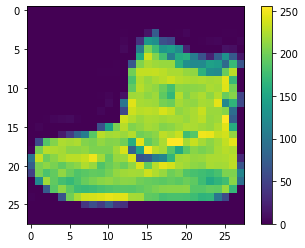

In [40]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

Standardize the r/g/b pixel values to between zero and one.

In [41]:
train_images = train_images / 255.0

test_images = test_images / 255.0

Let's see what these look like!

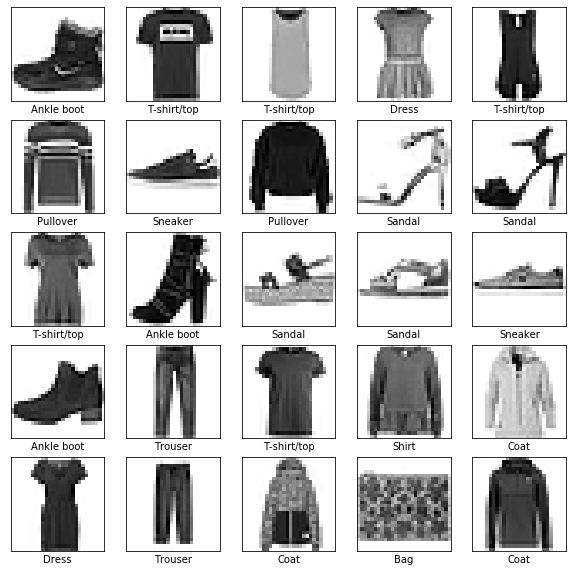

In [42]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

Now that we've seen what these images look like and made them consumable by a TensorFlow 2.0 model, let's construct such a model and plug them in.

In [78]:
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd


# Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`.

def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    c = np.log(np.expm1(1.))
    return tf.keras.Sequential([
      tfp.layers.VariableLayer(2 * n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t[..., :n],
                     scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
          reinterpreted_batch_ndims=1)),
  ])

# Specify the prior over `keras.layers.Dense` `kernel` and `bias`.

def prior_trainable(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    return tf.keras.Sequential([
      tfp.layers.VariableLayer(n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t, scale=1),
          reinterpreted_batch_ndims=1)),
    ])


model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    tfp.layers.DenseVariational(128, activation='relu', make_posterior_fn=posterior_mean_field, make_prior_fn=prior_trainable,),
    keras.layers.Dense(10, activation='softmax')
])

For a loss function, we'll choose sparse softmax cross entropy loss between logit outputs and labels -- this is a great loss function for mutually exclusive discrete classification tasks.

In [79]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # tf.nn.sparse_softmax_cross_entropy_with_logits
              metrics=['accuracy'])

In [147]:
model.fit(train_images, train_labels, epochs=15)

Train on 60000 samples
Epoch 1/15
60000/60000 [==============================] - 15s 250us/sample - loss: 75.1981 - accuracy: 0.2277
Epoch 2/15
60000/60000 [==============================] - 16s 262us/sample - loss: 74.6056 - accuracy: 0.2274
Epoch 3/15
60000/60000 [==============================] - 15s 257us/sample - loss: 74.8590 - accuracy: 0.2356
Epoch 4/15
60000/60000 [==============================] - 15s 250us/sample - loss: 74.6936 - accuracy: 0.2315
Epoch 5/15
60000/60000 [==============================] - 16s 266us/sample - loss: 74.7198 - accuracy: 0.2366
Epoch 6/15
60000/60000 [==============================] - 16s 262us/sample - loss: 74.8067 - accuracy: 0.2382
Epoch 7/15
60000/60000 [==============================] - 16s 270us/sample - loss: 74.8995 - accuracy: 0.2417
Epoch 8/15
60000/60000 [==============================] - 17s 277us/sample - loss: 75.1317 - accuracy: 0.2410
Epoch 9/15
60000/60000 [==============================] - 21s 344us/sample - loss: 74.5010 - accu

In [148]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

10000/1 - 1s - loss: 68.4164 - accuracy: 0.2536

Test accuracy: 0.2536


Our model trains fairly quickly, even without a GPU. Fortunately, it's small and fairly shallow as deep neural networks go. Let's take a look at the predictions.

In [1]:
predictions = model.predict(test_images)
predictions[0], predictions[1]

NameError: name 'model' is not defined

In [166]:
predictions[0:10]

array([[1.33546274e-02, 1.86460745e-02, 1.87415611e-02, 2.70384159e-02,
        1.14485780e-02, 3.75899762e-01, 3.15141268e-02, 4.33859527e-01,
        3.60986441e-02, 3.33986878e-02],
       [5.45647629e-02, 1.14918508e-01, 2.81161554e-02, 1.55736119e-01,
        4.78629887e-01, 1.59111205e-05, 1.42192051e-01, 1.12020120e-04,
        2.43874248e-02, 1.32716028e-03],
       [4.71064681e-03, 1.65828355e-02, 2.80265491e-02, 1.29769994e-02,
        7.91572630e-02, 9.71135590e-03, 1.69753835e-01, 4.54713047e-01,
        1.15250930e-01, 1.09116554e-01],
       [4.44595441e-02, 9.06635672e-02, 6.24554791e-02, 9.34557542e-02,
        8.43452588e-02, 1.57712903e-02, 3.53401363e-01, 1.40161306e-01,
        7.44685084e-02, 4.08179834e-02],
       [8.95858556e-02, 2.14443415e-01, 4.23013829e-02, 1.80991173e-01,
        1.02198109e-01, 2.78947316e-02, 1.43483624e-01, 9.28018093e-02,
        7.42762163e-02, 3.20237093e-02],
       [2.73124501e-03, 8.62224214e-03, 2.34188270e-02, 1.13034351e-02,
   

Our softmax function effectively squished the model outputs into a distribution and seems to be most heavily activated on class 9. Let's verify that.

In [167]:
np.argmax(predictions[0])

7

In [168]:
test_labels[0]

9

In [169]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array, true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array, true_label[i]
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

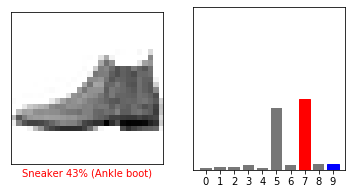

In [170]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

Question: are the other outputs of the softmax function probabilities?

Let's now try to plot predictions from the test set generally and see how well we're doing.

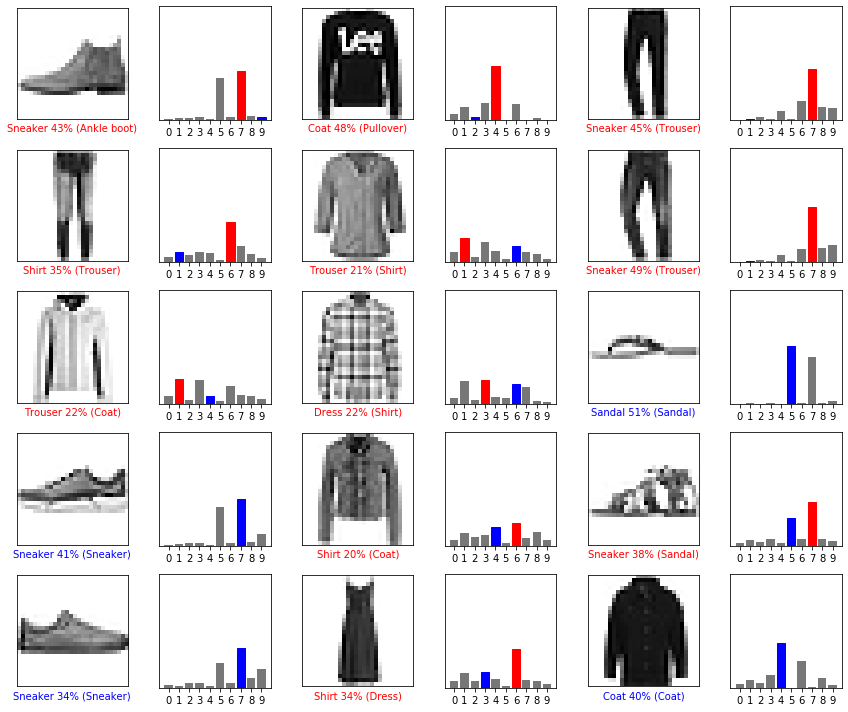

In [171]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions[i], test_labels, test_images)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

Evaluate uncertainties!